In [ ]:
# Author: Yuki Rivera
# This notebook implements the code to evaluate the trained RNN model

In [ ]:
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import matplotlib.pyplot as plt
import umap
from tensorflow.keras.layers import Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model


In [ ]:
perp_file_path = 'test_perplexity_rnn.txt'

### Hyperparameters used for training

In [ ]:
word_limit = 40000
vocab_size = 40000
enc_max_len = 64  # the prompt length
dec_max_len = 150   # the synopsis length

max_dec_input_length = dec_max_len - 1  # decoder input length

max_generated_length = 50  # sets the limit for generated text

embedding_dim = 128 # output_dim
units = 128

batch = 64
repeat = 20 # num of epochs
patience = 3 # early-stopping patience

val_ratio = 0.2 # validation set ratio

min_delta = 0.01

dropout_rate = 0.3
output_dim = 128

### Load the training history, the model and the tokenizer

In [ ]:
# Loads tokenizer
with open("tokenizer_RNN.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Loads model
    model = load_model("best_model_RNN.keras")

In [ ]:
start_token_id = tokenizer.word_index.get('<BOS>') 
end_token_id = tokenizer.word_index.get('<EOS>')   
oov_token_id = tokenizer.word_index.get('<OOV>')
pad_token_id = tokenizer.word_index.get('<PAD>')

### Loads the testing data

In [ ]:
df = pd.read_csv('prompt_synopsis_test.csv')

In [ ]:
# pd.set_option('display.max_colwidth', None)
# testing_df.head(50)

### Select 20 pairs for testing

In [ ]:
testing_df = df.iloc[[20, 26, 64,84,88,98,106,111,127,164,190,199,225,231,242,244,259,298, 10597, 10609]]
testing_df = testing_df.reset_index(drop=True)

In [ ]:
testing_df.head()

,prompt,synopsis,tags_combined
0,Write an anime synopsis that matches 'Adventur...,on one noteworthy day in the adventurer's guil...,adventure comedy fantasy
1,Write an anime synopsis that matches 'Mystery ...,the anime is set in the fictional geso ward in...,mystery supernatural
2,Generate a 'Historical and Mythology' themed a...,"in the nineteenth century, we find lydia carlt...",historical mythology shoujo
3,Write an anime synopsis that matches 'Adventure'.,takashi loves reading books and especially lov...,adventure
4,"Create an anime synopsis with 'Comedy, Fantasy...",in a city filled with anthropomorphic catpeopl...,anthropomorphic comedy fantasy slice of life


In [ ]:
prompts = testing_df["prompt"].tolist()
references = testing_df["synopsis"].tolist()
tags_list = testing_df['tags_combined'].tolist()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 149)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 64, 128)   │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 149, 128)  │  1,920,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn         │ [(None, 128),     │     32,896 │ encoder_embeddin… │
│ (SimpleRNN)         │ (None, 128)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn         │ [(None, 149,      │     32,896 │ decoder_embeddin… │
│ (SimpleRNN)         │ 128), (None,      │            │ encoder_rnn[0][1] │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 149,       │  1,935,000 │ decoder_rnn[0][0] │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,522,378 (66.84 MB)

 Trainable params: 5,840,792 (22.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,681,586 (44.56 MB)

### Build the inference models (Encoder and Decoder separately)

In [ ]:
# Encoder
# Input: The raw token IDs of the prompt
encoder_inputs_inf = Input(shape=(enc_max_len,), name='encoder_input_inference')

# Gets the Embedding layer from the trained model
encoder_embedding_inf_layer = model.get_layer('encoder_embedding')

# Gets the RNN layer from the trained model
encoder_rnn_layer = model.get_layer('encoder_rnn')

# Connects the input through the embedding layer first to get 3D tensor
encoder_embedding_output_inf = encoder_embedding_inf_layer(encoder_inputs_inf)

# Feeds the 3D embedded input to the RNN layer
_, state_h_enc_inf = encoder_rnn_layer(encoder_embedding_output_inf)

# The encoder inference model outputs the final hidden state
encoder_states_inf = state_h_enc_inf

encoder_model = Model(inputs=encoder_inputs_inf, outputs=encoder_states_inf)

In [ ]:
# Decoder

# Input for the single token that the decoder will receive at each step of inference.
decoder_input_single_token_inf = Input(shape=(1,), name='decoder_input_inference_token')

# Input for the previous decoder state
decoder_state_input_h_inf = Input(shape=(units,), name='decoder_state_input_h_inf')


# Gets the relevant layers from the loaded training_model by their names.
decoder_embedding_inf_layer = model.get_layer('decoder_embedding')
decoder_rnn_inf_layer = model.get_layer('decoder_rnn') 
decoder_dense_inf_layer = model.get_layer('decoder_output')

# Connects the single token input to the decoder's embedding layer.
decoder_embedding_output_inf = decoder_embedding_inf_layer(decoder_input_single_token_inf)

# Connects the embedded token and previous state to the decoder RNN layer.
decoder_outputs_inf_sequence, state_h_dec_inf = decoder_rnn_inf_layer(
    decoder_embedding_output_inf, initial_state=decoder_state_input_h_inf
)

# Connects the decoder RNN's sequence output to the final dense layer to get probabilities.
decoder_outputs_prob_inf = decoder_dense_inf_layer(decoder_outputs_inf_sequence)


decoder_model = Model(
    inputs=[decoder_input_single_token_inf, decoder_state_input_h_inf], # Inputs: token + h state
    outputs=[decoder_outputs_prob_inf, state_h_dec_inf] # Outputs: probabilities + new h state
)

### Preprocess the testing data

In [ ]:
def clean_text(text):
    return str(text).lower().strip()

In [ ]:
for col in ['prompt', 'synopsis']:
    testing_df[col] = testing_df[col].astype(str).apply(clean_text)

test_prompt_seqs = tokenizer.texts_to_sequences(testing_df['prompt'].tolist())
test_synopsis_seqs = tokenizer.texts_to_sequences(testing_df['synopsis'].tolist())

# adds special tokens for decoder input/target
test_decoder_input_ids = [[start_token_id] + seq for seq in test_synopsis_seqs]
test_decoder_target_ids = [seq + [end_token_id] for seq in test_synopsis_seqs]

# pads all sequences
X_enc_test = pad_sequences(test_prompt_seqs, maxlen=enc_max_len, padding='post', value=pad_token_id)
X_dec_test = pad_sequences(test_decoder_input_ids, maxlen=max_dec_input_length, padding='post', value=pad_token_id)

y_test = pad_sequences(test_decoder_target_ids, maxlen=max_dec_input_length, padding='post', value=pad_token_id)

# reshapes target for sparse_categorical_crossentropy
y_test = np.expand_dims(y_test, axis=-1)

### Calculates the perplexity and saves to a text file

In [ ]:
rnn_test_results = model.evaluate([X_enc_test, X_dec_test], y_test, verbose=0)
rnn_test_loss = rnn_test_results[0] if isinstance(rnn_test_results, list) else rnn_test_results

# calculates perplexity
rnn_test_perplexity = np.exp(rnn_test_loss)

print(f"Final RNN Test Perplexity: {rnn_test_perplexity:.2f}")

Final RNN Test Perplexity: 225.52


In [ ]:
with open(perp_file_path, 'w') as f:
    f.write(str(rnn_test_perplexity))

### Adds Temprature Sampling (adds more randomeness to get diverse output)

In [ ]:
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Function to generate synopsis

In [ ]:
def generate_synopsis(prompt, encoder_model, decoder_model, tokenizer, max_words=max_generated_length, temp=0.7):

    input_seq = tokenizer.texts_to_sequences([prompt])
    padded_input_seq = pad_sequences(input_seq, maxlen=enc_max_len, padding='post', truncating='post', value=pad_token_id)

    # gets the final hidden state from the encoder_model by feeding the padded input
    states_value = encoder_model.predict(padded_input_seq, verbose=0)

    target_seq = np.zeros((1, 1), dtype='int32')
    target_seq[0, 0] = start_token_id

    stop_condition = False
    generated_synopsis_ids = []

    while not stop_condition:
        # gets the prob distribution over the entire vocab for the next token by feeding the token input to the decoder
        # as well as gets the hidden state
        output_tokens, h = decoder_model.predict([target_seq, states_value], verbose=0)

        # gets the output id that was chosen
        sampled_token_index = sample_with_temperature(output_tokens[0, 0, :], temperature=temp)

        # adds the newly predicted token id to the list
        generated_synopsis_ids.append(sampled_token_index)

        # checks for the stop conditions
        if sampled_token_index == end_token_id:
            stop_condition = True
        if len(generated_synopsis_ids) >= max_words:
            stop_condition = True

        # the token that was predicted becomes the input for the next step
        target_seq = np.zeros((1, 1), dtype='int32')
        target_seq[0, 0] = sampled_token_index

        # updates the decoder's hidden state to the newly computed state
        states_value = h

    generated_words = []

    for token_id in generated_synopsis_ids:
        if token_id == end_token_id: # Stop adding words after <EOS> token
            break
        word = tokenizer.index_word.get(token_id)
        if word in {'<OOV>', '<PAD>'}:
            continue
        elif word is not None and token_id != start_token_id: 
            generated_words.append(word)

    generated_text = ' '.join(generated_words)
    return generated_text

### Generates synopsis, computes cosine similarity for each pair, prints the result

In [ ]:
def evaluate_outputs(model, tokenizer, prompts, references, tags_combined, enc_max_len, dec_max_len, print_count=10):

    # Loads the pre-trained model for creating sentence embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    results = []

    for i in range(len(prompts)):
        # Gets all the data for the current row
        prompt = prompts[i]
        true_synopsis = references[i]
        tags = tags_combined[i]

        # Generates a new synopsis from the full prompt
        generated_synopsis = generate_synopsis(
            prompt=prompt, encoder_model=encoder_model, decoder_model=decoder_model,tokenizer=tokenizer, max_words=dec_max_len
        )


        # Creates embeddings for the tags and the generated synopsis.
        emb_tags = embedding_model.encode(tags)
        emb_generated = embedding_model.encode(generated_synopsis)

        # Calculates the cosine similarity between the tags and the generated text.
        similarity = cosine_similarity([emb_tags], [emb_generated])[0][0]

        # Stores all relevant information in the results dictionary
        results.append({
            "tags_combined": tags,
            "prompt": prompt,
            "generated": generated_synopsis,
            "true_synopsis": true_synopsis, 
            "cosine_similarity": similarity
        })

        # Prints the first few results for manual inspection
        if i < print_count:
            print(f"\nPrompt {i+1}: {prompt}")
            print(f"Generated: {generated_synopsis}")
            print(f"True:      {true_synopsis}")
            print(f"Cosine Similarity: {similarity:.3f}")
            print("—" * 50)

    return results

In [ ]:
results = evaluate_outputs(model, tokenizer, prompts, references, tags_list, enc_max_len, dec_max_len)

Inside generate_synopsis — type of tokenizer: <class 'keras.src.legacy.preprocessing.text.Tokenizer'>

Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: the anime of the school the first childhood anime episodes of the high school to fulfill the of the and the wall is a beautiful it has are a man that even the show is to the club to find her and the of while the that there is attacked by the
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with anoth

### Computs the avg cosine similarity and saves it to a text file

In [ ]:
avg_similarity = sum(r["cosine_similarity"] for r in results) / len(results)

In [ ]:
with open('avg_sim_transformer.txt', 'w') as f:
    f.write(str(avg_similarity))

### Saves all the results to a csv file

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("generated_results_with_similarity_calc.csv", index=False)

### Creates a table for comparison

In [ ]:
# shows full text in cells
pd.set_option('display.max_colwidth', None)

# displays a table nicely
df_results.head(10).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])


,tags_combined,prompt,generated,true_synopsis,cosine_similarity
0,adventure comedy fantasy,"Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.",the anime of the school the first childhood anime episodes of the high school to fulfill the of the and the wall is a beautiful it has are a man that even the show is to the club to find her and the of while the that there is attacked by the,"on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off more than he can chew.",0.254905
1,mystery supernatural,Write an anime synopsis that matches 'Mystery and Supernatural'.,"an story of the is the they to the thief by than the way to the and a known as the of her who is an 11yearold that that the are someone in the of his own other and his he in the and the that the only haru was as the of their father, his former death.","the anime is set in the fictional geso ward in tokyo, a school city where an app called aicis is becoming popular. those who get the app are given supernatural powers, which they use to pursue their own selfish desires, leading to many occurrences of violence and other incidents. the story focuses on a group of detectives who solve cases related to power wielders.",0.307352
2,historical mythology shoujo,Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'.,the is a young boy who incredibly who has been with the and and the interhigh battle.,"in the nineteenth century, we find lydia carlton living in scotland, making a living as a fairy doctor. she is one of those rare humans who can see and communicate with fairies. but no one believes her. however, edgar is in need of someone with a vast knowledge of fairy lore, and lydia is just that person. after rescuing her, he becomes her employer, but there are many secrets and emotions that seem to follow edgar, who claims to be the blue knight's earl.",0.245607
3,adventure,Write an anime synopsis that matches 'Adventure'.,"a series of the world of the human but is willing to be able to cute to his when it are the way, in the world. is completely by the by a two and and as the and allow a new and the entire season.","takashi loves reading books and especially loves alice's adventures in wonderland. one day, he buys some used books, and he finds one book thrown in. when takashi opens the book, the god of math m1 appeared. takashi is told that alice is kidnapped, and he's asked to rescue her by m1. and takashi goes on an adventure in wonderland to rescue alice.",0.386848
4,anthropomorphic comedy fantasy slice of life,"Create an anime synopsis with 'Comedy, Fantasy and Slice Of Life' and 'Anthropomorphic'.",by the of ruthless ceremony within the two high school episodes and,"in a city filled with anthropomorphic catpeople, catman lives free of rules and boundaries, doing everything he wants, which often collides with the other inhabitants of the city. created entirely in flash, with no spoken dialog, catman instead speaks in english and japanese subtitles. the series is spread across three socalled 'seasons', with only the third having been aired.",0.167646
5,action adventure drama romance sci-fi,"Write an anime synopsis that matches 'Action, Adventure, Drama, Romance and Sci-Fi'.","is a a witch and the followed and the girls about the strange however, in the the with him for her allowing he

### Visualizing Tags vs Output Embeddings Scatter Plot Using UMAP

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


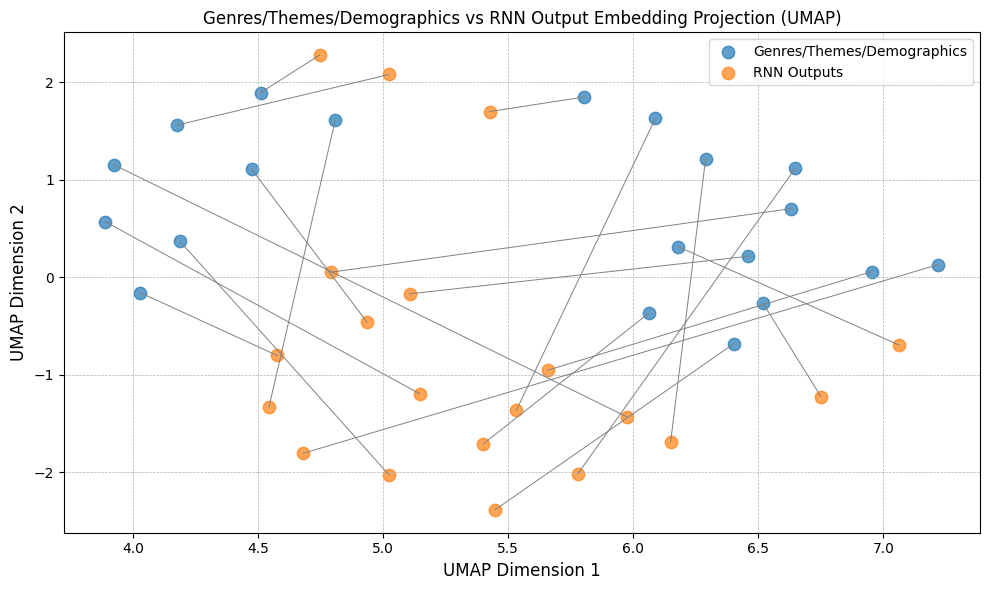

In [ ]:
# extracts the tags and generated synopsis from the results list
tags_to_match = [row["tags_combined"] for row in results]
generated_outputs = [row["generated"] for row in results]

# converts each prompt and generated output into a high-dim vector
tags_embeddings = embedding_model.encode(tags_to_match)
output_embeddings = embedding_model.encode(generated_outputs)

# combines both embeddings into a single array
all_embeddings = np.vstack([tags_embeddings, output_embeddings])

# reduces the dimension for visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

# splits embeddings into the tags and the output
n = len(tags_to_match)
umap_tags = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

# plots a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(umap_tags[:, 0], umap_tags[:, 1], label="Genres/Themes/Demographics", alpha=0.7, s=80)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="RNN Outputs", alpha=0.7, s=80)

# draws light gray lines to show the differences between the tag vs output
for i in range(n):
    plt.plot([umap_tags[i, 0], umap_outputs[i, 0]],
             [umap_tags[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.7)

plt.title("Genres/Themes/Demographics vs RNN Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig(
    'scatter_plot_rnn.png',
    dpi=300,
    bbox_inches='tight' 
)
plt.tight_layout()
plt.show()